In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from tensorflow.keras import datasets, layers, models, losses, Model

# preprocessing

In [2]:
train_ds, ds_info = tfds.load('imagenette', split='train', with_info=True)
val_ds = tfds.load('imagenette', split='validation', with_info=False)

print(train_ds)
print(val_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling imagenette-train.tfrecord...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling imagenette-validation.tfrecord...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to /aiffel/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.
<PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


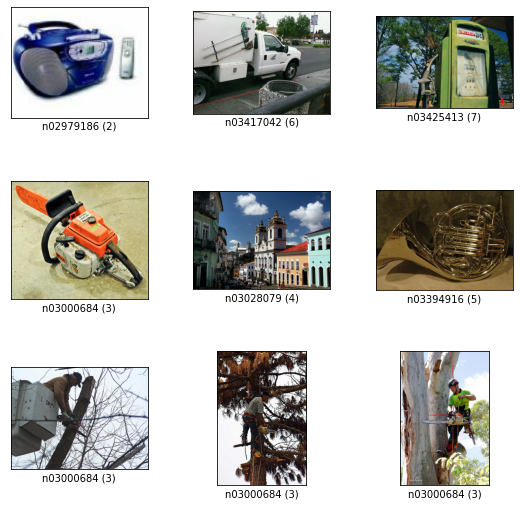

In [3]:
fig = tfds.show_examples(train_ds, ds_info)

In [4]:
# label을 출력합니다
ds_info.features["label"].names

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [5]:
# Number of classes: 10
num_classes = ds_info.features['label'].num_classes
print("num_classes: ", num_classes)

# Number of images: train 9469 / validation 3925
num_train_imgs = ds_info.splits['train'].num_examples
num_val_imgs = ds_info.splits['validation'].num_examples
print("num_train_imgs: ", num_train_imgs)
print("num_val_imgs: ", num_val_imgs)

num_classes:  10
num_train_imgs:  9469
num_val_imgs:  3925


In [6]:
import math
import functools

input_shape = [224, 224, 3]
batch_size = 256
num_epochs = 40

def _prepare_data_fn(features, input_shape, augment=False):
    """
    Resize image to expected dimensions, and opt. apply some random transformations.
    이미지 resizing, augmentation 등을 수행합니다.
    
    - features: Data
    - input_shape: Shape expected by the models (images will be resized accordingly)
    - augment: Flag to apply some random augmentations to the images
    - return: Augmented Images, Labels
    """
    input_shape = tf.convert_to_tensor(input_shape)

    # Tensorflow-dataset returns batches as feature dictionaries, expected by Estimators. 
    # To train Keras models, it is more straightforward to return the batch content as tuples. 

    image = features['image']
    label = features['label']

    # 이미지 픽셀 값의 범위를 [0, 255]에서 [0, 1.]로 normalize 합니다.
    image = tf.image.convert_image_dtype(image, tf.float32)

    if augment:

        # 무작위 좌우대칭
        image = tf.image.random_flip_left_right(image)

        # 무작위 밝기/포화도 변화
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.clip_by_value(image, 0.0, 1.0) # 픽셀 값이 범위 밖으로 넘어가지 않게 확인
        image = tf.image.resize(image, input_shape[:2])

        
    else:
        image = tf.image.resize(image, input_shape[:2])

    return image, label




prepare_data_fn_for_train = functools.partial(_prepare_data_fn, 
                                              input_shape=input_shape,
                                              augment=True)

train_ds = train_ds.repeat(num_epochs).shuffle(2023)

train_ds = train_ds.map(prepare_data_fn_for_train, num_parallel_calls=4)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(1)


# # 배치 크기 적용
# train_ds = train_ds.batch(batch_size)
# train_ds = train_ds.prefetch(1)


# validation dataset (섞거나 증강시키지 않음)
prepare_data_fn_for_val = functools.partial(_prepare_data_fn,
                                           input_shape=input_shape,
                                           augment=False)


val_ds = (val_ds.repeat().map(prepare_data_fn_for_val, num_parallel_calls=4)
                         .batch(batch_size)
                         .prefetch(1))


train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(256, 224, 224, 3)
(256,)


In [8]:
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(256, 224, 224, 3)
(256,)


# architecture

In [9]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [10]:
inp = layers.Input(shape=input_shape)
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape)(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [11]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [12]:
model.compile(optimizer='adam', 
              loss=[losses.sparse_categorical_crossentropy, 
                    losses.sparse_categorical_crossentropy, 
                    losses.sparse_categorical_crossentropy], 
              loss_weights=[1, 0.3, 0.3], 
              metrics=['accuracy'])

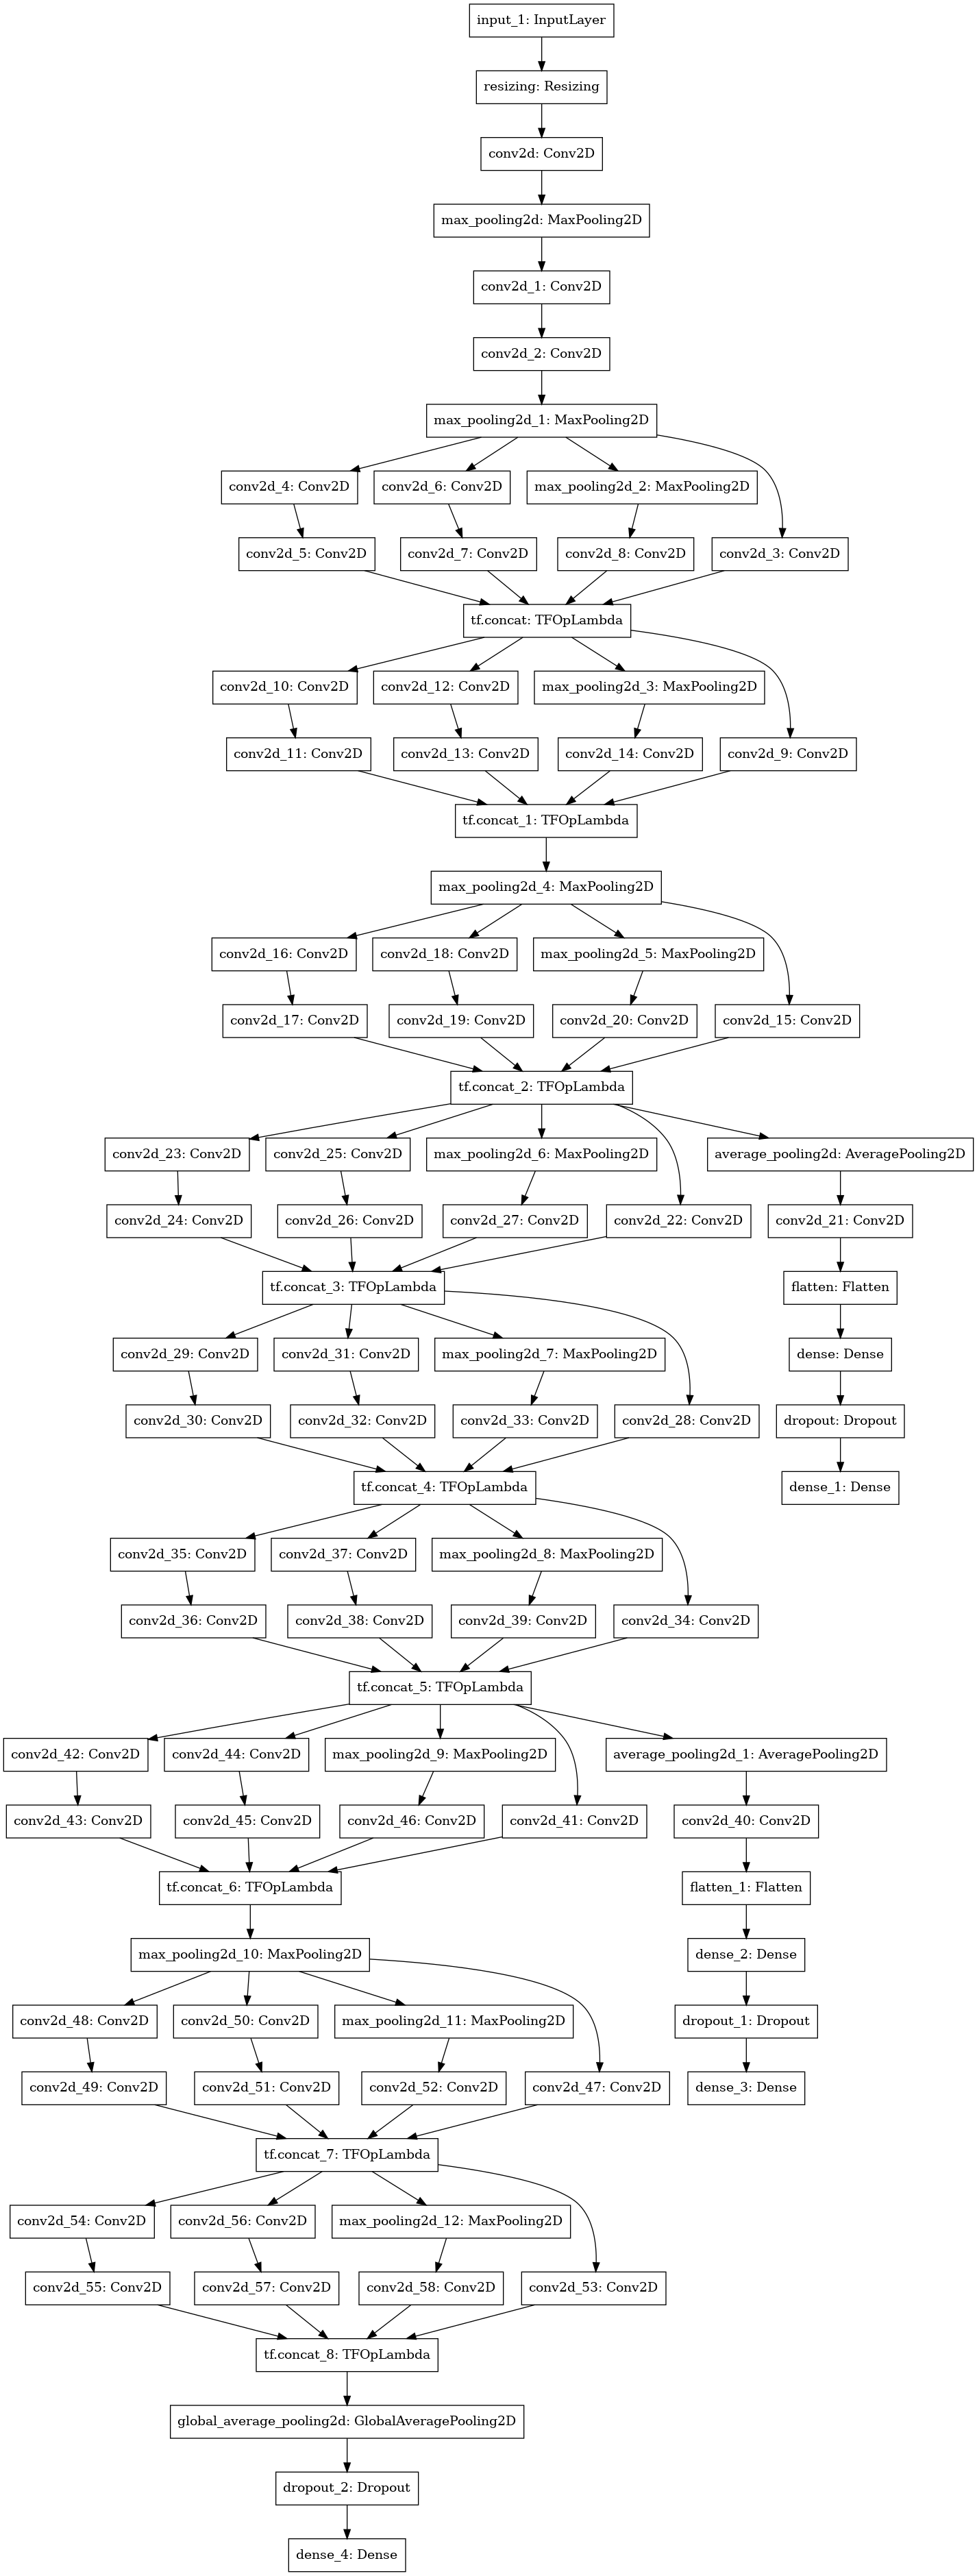

In [13]:
tf.keras.utils.plot_model(model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        resizing[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 55, 55, 64)   0           conv2d[0][0]                     
______________________________________________________________________________________________

# train

In [15]:
history = model.fit(train_ds,
                    validation_data=val_ds, 
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_steps=val_steps_per_epoch,
                    verbose=1,)

Epoch 1/40
37/37 [==============================] - 95s 1s/step - loss: 3.6629 - dense_4_loss: 2.2943 - dense_1_loss: 2.2749 - dense_3_loss: 2.2869 - dense_4_accuracy: 0.1161 - dense_1_accuracy: 0.1394 - dense_3_accuracy: 0.1270 - val_loss: 3.5132 - val_dense_4_loss: 2.2062 - val_dense_1_loss: 2.1959 - val_dense_3_loss: 2.1609 - val_dense_4_accuracy: 0.1792 - val_dense_1_accuracy: 0.2209 - val_dense_3_accuracy: 0.2170
Epoch 2/40
37/37 [==============================] - 47s 1s/step - loss: 3.4982 - dense_4_loss: 2.2058 - dense_1_loss: 2.1465 - dense_3_loss: 2.1614 - dense_4_accuracy: 0.1751 - dense_1_accuracy: 0.2133 - dense_3_accuracy: 0.1971 - val_loss: 3.3915 - val_dense_4_loss: 2.1482 - val_dense_1_loss: 2.0577 - val_dense_3_loss: 2.0866 - val_dense_4_accuracy: 0.2078 - val_dense_1_accuracy: 0.2646 - val_dense_3_accuracy: 0.2305
Epoch 3/40
37/37 [==============================] - 46s 1s/step - loss: 3.3424 - dense_4_loss: 2.1167 - dense_1_loss: 2.0323 - dense_3_loss: 2.0535 - dense_

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, num_epochs + 1)
plt.plot(epochs, acc, "r.", label="Train acc")
plt.plot(epochs, val_acc, "g", label="Val acc")
plt.title("Train & val acc.")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "r.", label="Train loss")
plt.plot(epochs, val_loss, "g", label="Val loss")
plt.title("Train & val loss")
plt.legend()
plt.show()

In [20]:
history.history.keys()

dict_keys(['loss', 'dense_4_loss', 'dense_1_loss', 'dense_3_loss', 'dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy', 'val_loss', 'val_dense_4_loss', 'val_dense_1_loss', 'val_dense_3_loss', 'val_dense_4_accuracy', 'val_dense_1_accuracy', 'val_dense_3_accuracy'])

In [23]:
acc1 = history.history["dense_1_accuracy"]
acc3 = history.history["dense_3_accuracy"]
acc4 = history.history["dense_4_accuracy"]

val_acc1 = history.history["val_dense_1_accuracy"]
val_acc3 = history.history["val_dense_3_accuracy"]
val_acc4 = history.history["val_dense_4_accuracy"]

loss1 = history.history["dense_1_loss"]
loss3 = history.history["dense_3_loss"]
loss4 = history.history["dense_4_loss"]

val_loss1 = history.history["val_dense_1_loss"]
val_loss3 = history.history["val_dense_3_loss"]
val_loss4 = history.history["val_dense_4_loss"]

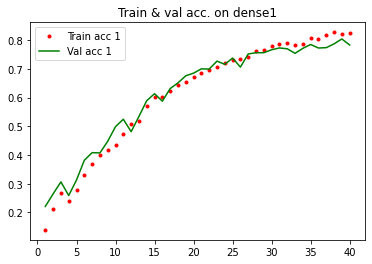

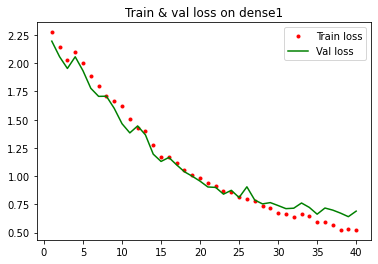

In [26]:
epochs = range(1, 40 + 1)
plt.plot(epochs, acc1, "r.", label="Train acc 1")
plt.plot(epochs, val_acc1, "g", label="Val acc 1")
plt.title("Train & val acc. on dense1")
plt.legend()
plt.figure()

plt.plot(epochs, loss1, "r.", label="Train loss")
plt.plot(epochs, val_loss1, "g", label="Val loss")
plt.title("Train & val loss on dense1")
plt.legend()
plt.show()

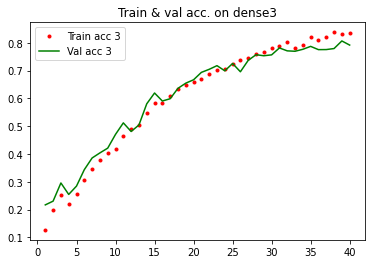

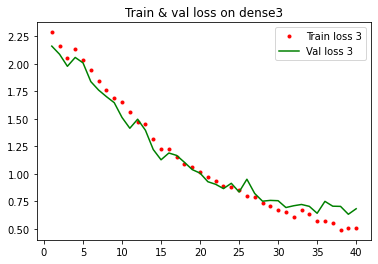

In [27]:
epochs = range(1, 40 + 1)
plt.plot(epochs, acc3, "r.", label="Train acc 3")
plt.plot(epochs, val_acc3, "g", label="Val acc 3")
plt.title("Train & val acc. on dense3")
plt.legend()
plt.figure()

plt.plot(epochs, loss3, "r.", label="Train loss 3")
plt.plot(epochs, val_loss3, "g", label="Val loss 3")
plt.title("Train & val loss on dense3")
plt.legend()
plt.show()

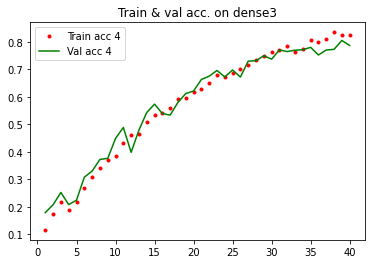

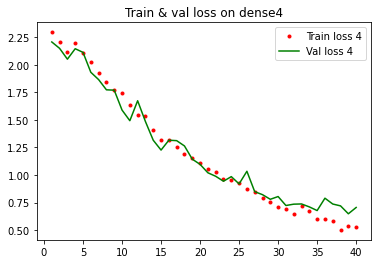

In [28]:
epochs = range(1, 40 + 1)
plt.plot(epochs, acc4, "r.", label="Train acc 4")
plt.plot(epochs, val_acc4, "g", label="Val acc 4")
plt.title("Train & val acc. on dense3")
plt.legend()
plt.figure()

plt.plot(epochs, loss4, "r.", label="Train loss 4")
plt.plot(epochs, val_loss4, "g", label="Val loss 4")
plt.title("Train & val loss on dense4")
plt.legend()
plt.show()

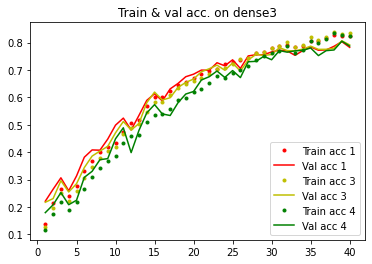

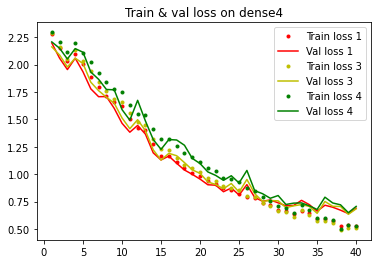

In [29]:
epochs = range(1, 40 + 1)

plt.plot(epochs, acc1, "r.", label="Train acc 1")
plt.plot(epochs, val_acc1, "r", label="Val acc 1")
plt.plot(epochs, acc3, "y.", label="Train acc 3")
plt.plot(epochs, val_acc3, "y", label="Val acc 3")
plt.plot(epochs, acc4, "g.", label="Train acc 4")
plt.plot(epochs, val_acc4, "g", label="Val acc 4")
plt.title("Train & val acc. on dense3")
plt.legend()
plt.figure()

plt.plot(epochs, loss1, "r.", label="Train loss 1")
plt.plot(epochs, val_loss1, "r", label="Val loss 1")
plt.plot(epochs, loss3, "y.", label="Train loss 3")
plt.plot(epochs, val_loss3, "y", label="Val loss 3")
plt.plot(epochs, loss4, "g.", label="Train loss 4")
plt.plot(epochs, val_loss4, "g", label="Val loss 4")
plt.title("Train & val loss on dense4")
plt.legend()
plt.show()